# Before Start
### install packages numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn by
> !pip install numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn 

In [7]:
import os, sys
sys.path.append(os.path.join(*str(os.getcwd()).split('\\')[:-1]).replace(':',':\\'))
import riemannian_robust_m_estimator as rrm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, pickle
import math
from scipy.stats import chi2

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian


In [154]:
import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger('root').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Sample mean simulation code
1) Set $\mu=(0,0,...,1)$ and covariance matrix $\Sigma$ which is the same as hyperbolic(hyperboloid)/euclidean
2) Generate random samples $\mathbf{X} \in \mathbb{R}^{n \times d}$ from pre-specified distribution with $\mu$, covariance matrix $\Sigma$
3) Send to the tangent space of $\mu=(0,0,...,1)$ by adding 1 to the last axis and denote this as $\mathbf{X}'$.
4) Get $\mathbf{X}^* = Exp_{\mu}(\mathbf{X}')$ for manifold-valued sample, $Exp$ is the exponential map of the sphere manifold.

In [ ]:
def riemannian_sample_variance_comparison(manifold, mu, cov, n_samples, pop_dist_type = 'gaussian', sample_iter=100, seed=None):

    max_iter_graddescent = 2048
    epsilon = 1e-7
    cutoff_ptiles = [5,10,15,20,25,30,35,40,45,50,60,70,75,80,82.13,85,90,95,99,99.73]
    results = {
        'mean':{'fm':[],'gm':[],
               },
        'var':{'fm':[],'gm':[],
               },
        'sq_bias':{'fm':[],'gm':[],
               },
        'sample_mean_var':{},
        'sample_var_mean':{},
        'sample_var_var':{},
        'sq_bias_mean':{},
        'sq_bias_var':{},
        'invalid':[],
        'cov':cov,
        'distances':[],
        'cutoff':{}
    }
    if seed is not None:
        gs.random.seed(seed)
        my_rng = np.random.default_rng(seed=seed)
    else:
        my_rng = np.random.default_rng()

    for cutoff_pct in cutoff_ptiles:
        results['cutoff'][cutoff_pct] = []
    m_est_type_lb = {'mono':('huber',1.345),'softr':('cauchy',2.3849),'hardr':('hampel',1.35)}  #'hardr':('biweight',4.6851)
    
    for i in range(sample_iter):
        if pop_dist_type == 'gaussian':
            tangent_data = np.random.multivariate_normal(mean=mu[:-1], cov=cov, size=n_samples)
        elif pop_dist_type == 't':
            tangent_data = sample_mv_t(mean=mu[:-1], Sigma=cov, n=n_samples, nu=4, rng=my_rng)
        elif pop_dist_type == 'laplace':
            tangent_data = sample_mv_laplace(mean=mu[:-1], Sigma=cov, n=n_samples, rng=my_rng)
        elif pop_dist_type == 'NIG':
            tangent_data = sample_mv_nig(mean=mu[:-1], Sigma=cov, n=n_samples, alpha=1.5, delta=1.0, rng=my_rng)

       
        tangent_data = np.hstack((tangent_data, np.expand_dims(np.repeat(0,n_samples), -1)))
        logs = mu + tangent_data
        data = manifold.metric.exp(logs, mu)
       
        dists = manifold.metric.dist(data, mu)
        results['distances'].append(dists)
        if i==0:
            print(f'distances distribution(avg:{np.mean(dists):.2f}/max:{np.max(dists):.2f}/min:{np.min(dists):.2f})')

        fm = rrm.RiemannianRobustMestimator(
                    space=manifold,
                    method='default',
                    m_estimator='custom',
                    critical_value=None,
                    init_point_method='mean-projection',
                )
        fm.set_loss(squaredist)
        fm.set(init_step_size=0.5, max_iter=max_iter_graddescent, epsilon=epsilon)
        fm.fit(data)
                
        if len(fm.estimate_.losses)>max_iter_graddescent-50:
            results['invalid'].append(f'{res_lb}_{i}')
            results['mean'][res_lb].append(gs.array([9999]*len(data[0])))
            results['var'][res_lb].append(9999)
            results['sq_bias'][res_lb].append(9999)
        else:
            results['mean']['fm'].append(fm.estimate_.x)
            results['var']['fm'].append(
                rrm.riemannian_variance(manifold, data, base=fm.estimate_.x)
            )
            bias = fm.estimate_.x - mu
            results['sq_bias']['fm'].append(
                bias.T @ bias
            )
   
        gm = GeometricMedian(manifold, lr=0.5, max_iter=max_iter_graddescent, epsilon=epsilon)
        gm.fit(data)
        results['mean']['gm'].append(gm.estimate_)
        results['var']['gm'].append(
            rrm.riemannian_variance(manifold, data, base=gm.estimate_)
        )
        bias = gm.estimate_ - mu
        results['sq_bias']['gm'].append(
            bias.T @ bias
        )
       
        for cutoff_pct in cutoff_ptiles:
            ptile_ix = int(len(dists)*cutoff_pct/100)-1
            c = np.sort(dists)[ptile_ix]
            results['cutoff'][cutoff_pct].append(c)
            for m_est_tp,(m_est_lb,c_95) in m_est_type_lb.items():
                res_lb = f'{m_est_tp}_{cutoff_pct:.2f}'
                if res_lb not in results['mean'].keys():
                    results['mean'][res_lb] = []
                    results['var'][res_lb] = []
                    results['sq_bias'][res_lb] = []
                    
                # print(f'{res_lb}({c:.2f}) start')
                m_est = rrm.RiemannianRobustMestimator(
                    space=manifold, method='default', m_estimator=m_est_lb, critical_value=c,init_point_method='mean-projection',
                )
                m_est.set(init_step_size=5 if m_est_lb == 'biweight' else 0.5, max_iter=max_iter_graddescent, epsilon=epsilon)
                m_est.fit(data)
                if len(m_est.estimate_.losses)>max_iter_graddescent-50:
                    results['invalid'].append(f'{res_lb}_{i}')
                    results['mean'][res_lb].append(gs.array([9999]*len(data[0])))
                    results['var'][res_lb].append(9999)
                    results['sq_bias'][res_lb].append(9999)
                else:
                    results['mean'][res_lb].append(m_est.estimate_.x)
                    results['var'][res_lb].append(
                        rrm.riemannian_variance(manifold, data, base=m_est.estimate_.x)
                    )
                    bias = m_est.estimate_.x - mu
                    results['sq_bias'][res_lb].append(
                        bias.T @ bias
                    )
               

    for lb in results['mean'].keys():
        results['sample_mean_var'][lb] = rrm.riemannian_variance(manifold, gs.array([i for i in results['mean'][lb] if i[0]!=9999])),
        results['sample_var_mean'][lb] = np.mean([i for i in results['var'][lb] if i!=9999]),
        results['sample_var_var'][lb] = np.var([i for i in results['var'][lb] if i!=9999]),
        results['sq_bias_mean'][lb] = np.mean([i for i in results['sq_bias'][lb] if i!=9999]),
        results['sq_bias_var'][lb] = np.var([i for i in results['sq_bias'][lb] if i!=9999]),
       
    return results



# --------- Util ---------
def chol_psd_for_cov(Sigma, scale=1.0, eps=1e-12):
    """ make sure L L^T = Sigma / scale, numerically stable eig decomposition based 'Cholesky-like'."""
    Sigma = np.asarray(Sigma, float)
    vals, vecs = np.linalg.eigh(Sigma)
    vals = np.clip(vals, eps, None)
    target = vals / float(scale)
    return vecs @ np.diag(np.sqrt(target)) @ vecs.T

# Inverse-Gaussian(μ, λ) sampler (Michael–Schucany–Haas)
def sample_inverse_gaussian(mu, lam, size, rng):
    v = rng.standard_normal(size=size)
    y = v**2
    x = mu + (mu**2 * y)/(2*lam) - (mu/(2*lam))*np.sqrt(4*mu*lam*y + mu**2 * y**2)
    u = rng.uniform(size=size)
    w = np.where(u <= mu/(mu + x), x, (mu**2)/x)
    return w

# --------- 1) Student-t_ν (ν>2) ---------
def sample_mv_t(mean, Sigma, n, nu, rng=None):
    """
    mean: (d,), Sigma: (d,d), nu>2
    Auto-Scaling so that covariance matrix must be Sigma
    """
    assert nu > 2, "in case of Student-t, covariance matching needs ν>2."
    rng = np.random.default_rng() if rng is None else rng
    E_W = nu / (nu - 2.0)
    L = chol_psd_for_cov(Sigma, scale=E_W)
    G = rng.chisquare(df=nu, size=n)          # χ²_ν
    W = nu / G                                # mixture
    Z = rng.standard_normal((n, mean.size))   # N(0, I)
    X = mean + (np.sqrt(W)[:, None] * (Z @ L.T))
    return X

# --------- 2) Elliptical Laplace ---------
def sample_mv_laplace(mean, Sigma, n, rng=None):
    """
    eliptical Laplace: X|W ~ N(mean, W Sigma), W ~ Exp(1), E[W]=1
    -> L L^T = Sigma
    """
    rng = np.random.default_rng() if rng is None else rng
    L = chol_psd_for_cov(Sigma, scale=1.0)
    W = rng.exponential(scale=1.0, size=n)
    Z = rng.standard_normal((n, mean.size))
    X = mean + (np.sqrt(W)[:, None] * (Z @ L.T))
    return X

# --------- 3) NIG (symmetric, β=0) ---------
def sample_mv_nig(mean, Sigma, n, alpha=1.5, delta=1.0, rng=None):
    """
    symmetric NIG: W ~ IG(μ=δ/α, λ=δα), E[W]=δ/α
    -> L L^T = Sigma / (δ/α)
    (skewness β!=0 is possible, but then Var(W)ββ^T add to Cov, another scaling is required)
    """
    assert alpha > 0 and delta > 0
    rng = np.random.default_rng() if rng is None else rng
    muW = delta / alpha
    lamW = delta * alpha
    L = chol_psd_for_cov(Sigma, scale=muW)
    W = sample_inverse_gaussian(mu=muW, lam=lamW, size=n, rng=rng)
    Z = rng.standard_normal((n, mean.size))
    X = mean + (np.sqrt(W)[:, None] * (Z @ L.T))
    return X

def squaredist(space,points,base,critical_value,weights=None,loss_and_grad=True):
    n = len(points)
    logs = space.metric.log(points,base)
    dists = space.metric.dist(points,base)

    loss = gs.sum(dists**2)/n
    if not loss_and_grad:
        return loss
    grad = -2*gs.sum(logs,axis=0)/n
    return loss, space.to_tangent(grad,base)

    
# # --------- Usage Examples ---------
# if __name__ == "__main__":
#     d, n = 3, 10000
#     mu = np.zeros(d)
#     Sigma = np.array([[1.0, 0.6, 0.0],
#                       [0.6, 1.0, 0.2],
#                       [0.0, 0.2, 1.5]])

#     X_t   = sample_mv_t(mu, Sigma, n, nu=4.0)
#     X_lap = sample_mv_laplace(mu, Sigma, n)
#     X_nig = sample_mv_nig(mu, Sigma, n, alpha=1.8, delta=1.0)

#     # sample covariance matrix.(finite - sampling error exists.)
#     print(np.cov(X_t,   rowvar=False)[:2,:2])
#     print(np.cov(X_lap, rowvar=False)[:2,:2])
#     print(np.cov(X_nig, rowvar=False)[:2,:2])

# make covariance matrix(different effective rank($k_{eff}$)) code

In [ ]:
def eff_rank_by_diag_elements(x):
    return np.sum(x)/np.max(x)

dims = [2,5,10,20,50,100,500]

covs = {}
eranks = {}
mus = {}

for d in dims: 
    covs[d] = {}
    eranks[d] = {}
    mus[d] = np.array([0]*d+[1])
    for u in ['full-rank','half-rank','low-rank']:
        covs[d][u] = []
        eranks[d][u] = []

        if u=='full-rank':
            eigs = np.repeat(d,d)
        elif u=='half-rank':
            if d%2==1:
                eigs = np.array([d]*int(d/2)+[1]*int(d/2)+[0.5])
            if d%2==0:
                eigs = np.array([d]*int(d/2)+[0.01]*int(d/2))
        elif u=='low-rank':
            eigs = np.array([1]*max(1,int(d/10))+[0.0001]*(d-max(1,int(d/10))))
        
        eigs = eigs/np.sum(eigs)*0.10
        trace_cov = np.sum(eigs)
        eff_rank = eff_rank_by_diag_elements(eigs)
        
        covs[d][u].append(np.diag(eigs))
        eranks[d][u].append(eff_rank)

with open('means.pkl','wb') as f_:
    pickle.dump(mus,f_)
with open('covs.pkl','wb') as f_:
    pickle.dump(covs,f_)
with open('eranks.pkl','wb') as f_:
    pickle.dump(eranks,f_)

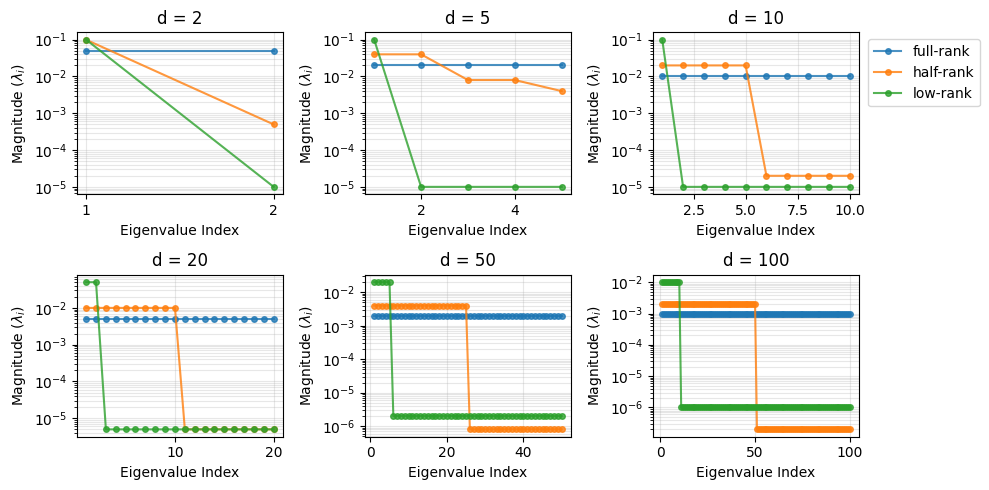

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_eigenvalue_panels(data_dict):
    dims = [2, 5, 10, 20, 50, 100]
    ranks = ['full-rank', 'half-rank', 'low-rank']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    axes = axes.flatten()

    for i, d in enumerate(dims):
        ax = axes[i]
        
        if d not in data_dict:
            ax.text(0.5, 0.5, f'Data for d={d} missing', ha='center')
            continue
            
        for idx, rank_type in enumerate(ranks):
            cov_matrix = data_dict[d][rank_type][0]
            eigs = np.diag(cov_matrix)
            
            eigs_sorted = np.sort(eigs)[::-1]
            
            ax.plot(range(1, d + 1), eigs_sorted, marker='o', markersize=4, 
                    label=rank_type, color=colors[idx], alpha=0.8)

        if d == 2:
            ax.set_xticks([1, 2])
        
        ax.set_title(f'd = {d}')
        ax.set_xlabel('Eigenvalue Index')
        ax.set_ylabel('Magnitude ($\lambda_i$)')
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="-", alpha=0.3)
        
        if i == 2:
            ax.legend(bbox_to_anchor=(1.01,1))

    plt.tight_layout()
    #plt.suptitle('Eigenvalue Profiles by Rank Scenarios and Dimensions', fontsize=16, y=1.02)
    plt.show()

# Usage Example:
plot_all_eigenvalue_panels(covs)

In [ ]:
with open('means.pkl','rb') as f_:
    mus = pickle.load(f_)
with open('covs.pkl','rb') as f_:
    covs = pickle.load(f_)

In [ ]:

n_sampless = [1000] #,300,25,100]
sampling_process_iter = 100

pop_dist_types = ['gaussian','t','laplace']

tic = time.time()

n_rand = 10

dims = [2,5,10,20,50,100,500] 
for i_c in range(n_rand):
    for n_samples in n_sampless:
        result_compr = {}
        for dim in dims:
            manifold = Hypersphere(dim)
            seed = 50+dim+i_c
            np.random.seed(seed)
            result_compr[dim] = {}
            
            mu = mus[dim]
                    
            for pop_dist_type in pop_dist_types:
                result_compr[dim][pop_dist_type] = {}
                
                for u,u_covs in covs[dim].items():
                    
                    res_ = riemannian_sample_variance_comparison(
                        manifold=manifold,
                        mu=mu,
                        cov=u_covs[0],
                        pop_dist_type=pop_dist_type,
                        n_samples=n_samples,
                        sample_iter=sampling_process_iter
                    )
                    result_compr[dim][pop_dist_type][u] = res_
                print(f'dimension {dim}, {u}, {pop_dist_type} done: {time.time()-tic} seconds elapsed...')

        with open(f'sphere/varofsamplemean_simul_n{n_samples}_cov3type_mest_{i_c}.pkl','wb') as f_:
            pickle.dump(result_compr,f_)

distances distribution(avg:0.28/max:0.80/min:0.00)
distances distribution(avg:0.26/max:1.06/min:0.00)
distances distribution(avg:0.25/max:1.09/min:0.00)
dimension 2, low-rank, gaussian done: 1576.4326882362366 seconds elapsed...
distances distribution(avg:0.24/max:1.58/min:0.00)
distances distribution(avg:0.22/max:2.97/min:0.00)
distances distribution(avg:0.22/max:2.84/min:0.00)
dimension 2, low-rank, t done: 3285.104064464569 seconds elapsed...
distances distribution(avg:0.25/max:1.13/min:0.00)
distances distribution(avg:0.24/max:2.27/min:0.00)
distances distribution(avg:0.22/max:1.64/min:0.00)
dimension 2, low-rank, laplace done: 4960.232086420059 seconds elapsed...
distances distribution(avg:0.30/max:0.78/min:0.09)
distances distribution(avg:0.30/max:0.73/min:0.06)
distances distribution(avg:0.24/max:1.15/min:0.00)
dimension 5, low-rank, gaussian done: 6411.91080904007 seconds elapsed...
distances distribution(avg:0.26/max:1.82/min:0.06)
distances distribution(avg:0.26/max:1.39/min:

## different random seed test (d=10, low-rank)

In [ ]:
n_rand = 10
n_sampless = [1000] #,300,25,100]
sampling_process_iter = 100

pop_dist_types = ['gaussian','t','laplace']

tic = time.time()

dims = [10]
for i_c in range(n_rand):
    for n_samples in n_sampless:
        result_compr = {}
        for dim in dims:
            seed = 5300+dim+i_c
            np.random.seed(seed)
            manifold = Hypersphere(dim)
            result_compr[dim] = {}
            
            mu = np.array([0.0]*dim)
                    
            for pop_dist_type in pop_dist_types:
                result_compr[dim][pop_dist_type] = {}
                
                for u,u_covs in covs[dim].items():
                    try:
                        res_ = riemannian_sample_variance_comparison(
                            manifold=manifold,
                            mu=mu,
                            cov=u_covs[0],
                            pop_dist_type=pop_dist_type,
                            n_samples=n_samples,
                            sample_iter=sampling_process_iter
                        )
                        result_compr[dim][pop_dist_type][u] = res_
                        print(f'[{i_c}] dimension {dim}, {u}, {pop_dist_type} done: {time.time()-tic} seconds elapsed...')
                    except ValueError:
                        print(f'[{i_c}] [dimension {dim}, {u}, {pop_dist_type}] norm exploding error ...')
                        
                
        with open(f'old_rawdata/sphere_3_seedtest/varofsamplemean_simul_n{n_samples}_dim10_cov3type_mest_{i_c}.pkl','wb') as f_:
            pickle.dump(result_compr,f_)

In [ ]:
n_rand = 10
n_sampless = [1000] #,300,25,100]
sampling_process_iter = 100

pop_dist_types = ['gaussian','t','laplace']

tic = time.time()

dims = [10]
for i_c in range(n_rand):
    for n_samples in n_sampless:
        result_compr = {}
        for dim in dims:
            
            manifold = Hypersphere(dim)
            result_compr[dim] = {}
            
            mu = np.array([0.0]*dim)
                    
            for pop_dist_type in pop_dist_types:
                result_compr[dim][pop_dist_type] = {}
                
                for u,u_covs in covs[dim].items():
                    try:
                        res_ = riemannian_sample_variance_comparison(
                            manifold=manifold,
                            mu=mu,
                            cov=u_covs[0],
                            pop_dist_type=pop_dist_type,
                            n_samples=n_samples,
                            sample_iter=sampling_process_iter
                        )
                        result_compr[dim][pop_dist_type][u] = res_
                        print(f'[{i_c}] dimension {dim}, {u}, {pop_dist_type} done: {time.time()-tic} seconds elapsed...')
                    except ValueError:
                        print(f'[{i_c}] [dimension {dim}, {u}, {pop_dist_type}] norm exploding error ...')
                        
                
        with open(f'old_rawdata/sphere_2_seedtest/varofsamplemean_simul_n{n_samples}_dim10_cov3type_mest_{i_c}.pkl','wb') as f_:
            pickle.dump(result_compr,f_)